In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import serial   
import datetime

/home/kelu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
ser=serial.Serial("/dev/ttyACM0",115200,timeout=2)
ser.baudrate=115200

In [11]:
def setmux(mux):
    ser.write(bytearray("write mux "+str(mux)+"\n",'ascii'))
    A = ser.readline()
    B = ser.readline()
    C = ser.readline()
    print(A)
def set():
    ser.write(bytearray("set mux\n",'ascii'))
    A = ser.readline()
    return A
def clr():
    ser.write(bytearray("clear mux\n",'ascii'))
    A = ser.readline()
    return A


In [5]:
ser.write(bytearray("set mux\n",'ascii'))
A = ser.readline()
B = ser.readline()

In [6]:
A, B

(b'run> set mux\r\n', b'run> ')

In [9]:
ser.write(bytearray("clear mux\n",'ascii'))
A = ser.readline()
B = ser.readline()

In [8]:
A, B

(b'clear mux\r\n', b'run> ')

In [15]:
setmux("0000")
ser.readline()

b''


b'run> write mux 0000\r\n'

In [13]:
ser.readline()

b''

In [14]:
while True:
    ser.readline()

KeyboardInterrupt: 

In [15]:
ser.write(bytearray("write mux "+str("FFFF")+"\n",'ascii'))
A = ser.readline()
B = ser.readline()
C = ser.readline()
D = ser.readline()

In [17]:
C = ser.readline()
D = ser.readline()

In [18]:
A,B,C,D

(b'write mux FFFF\r\n',
 b'MAX14866 writing started\r\n',
 b'MAX14866 writing ended\r\n',
 b'run> ')

In [97]:
def pulse(pon: int=200,poff:int=200,damp:int=2000):
    ser.write(bytearray("start acq "+str(pon)+" "+str(poff)+" "+str(damp)+"\n",'ascii'))
    A = ser.readline()
    B = ser.readline()
    C = ser.readline()
    D = ser.readline()
    return D



In [98]:
pulse()

b'Acquisition ended\r\n'

In [86]:
def dac(gain=200):
    ser.write(bytearray("write dac "+str(gain)+"\n",'ascii'))
    A = ser.readline()
    B = ser.readline()
    C = ser.readline()
    return B

In [99]:
def read():
    ser.write(bytearray('read\n','ascii'))
    A = ser.readline()
    B = ser.readline()
    C = ser.readline()
    D = ser.readline()
    S = [x.replace("b'","") for x in str(C).split(",") if len(x)]
    print(len(S))
    signal = [(int(x,16)-512)/512.0 for x in S[:-1]]
    return signal

8001
8001
8001
8001
8001
8001
8001
8001
8001
8001


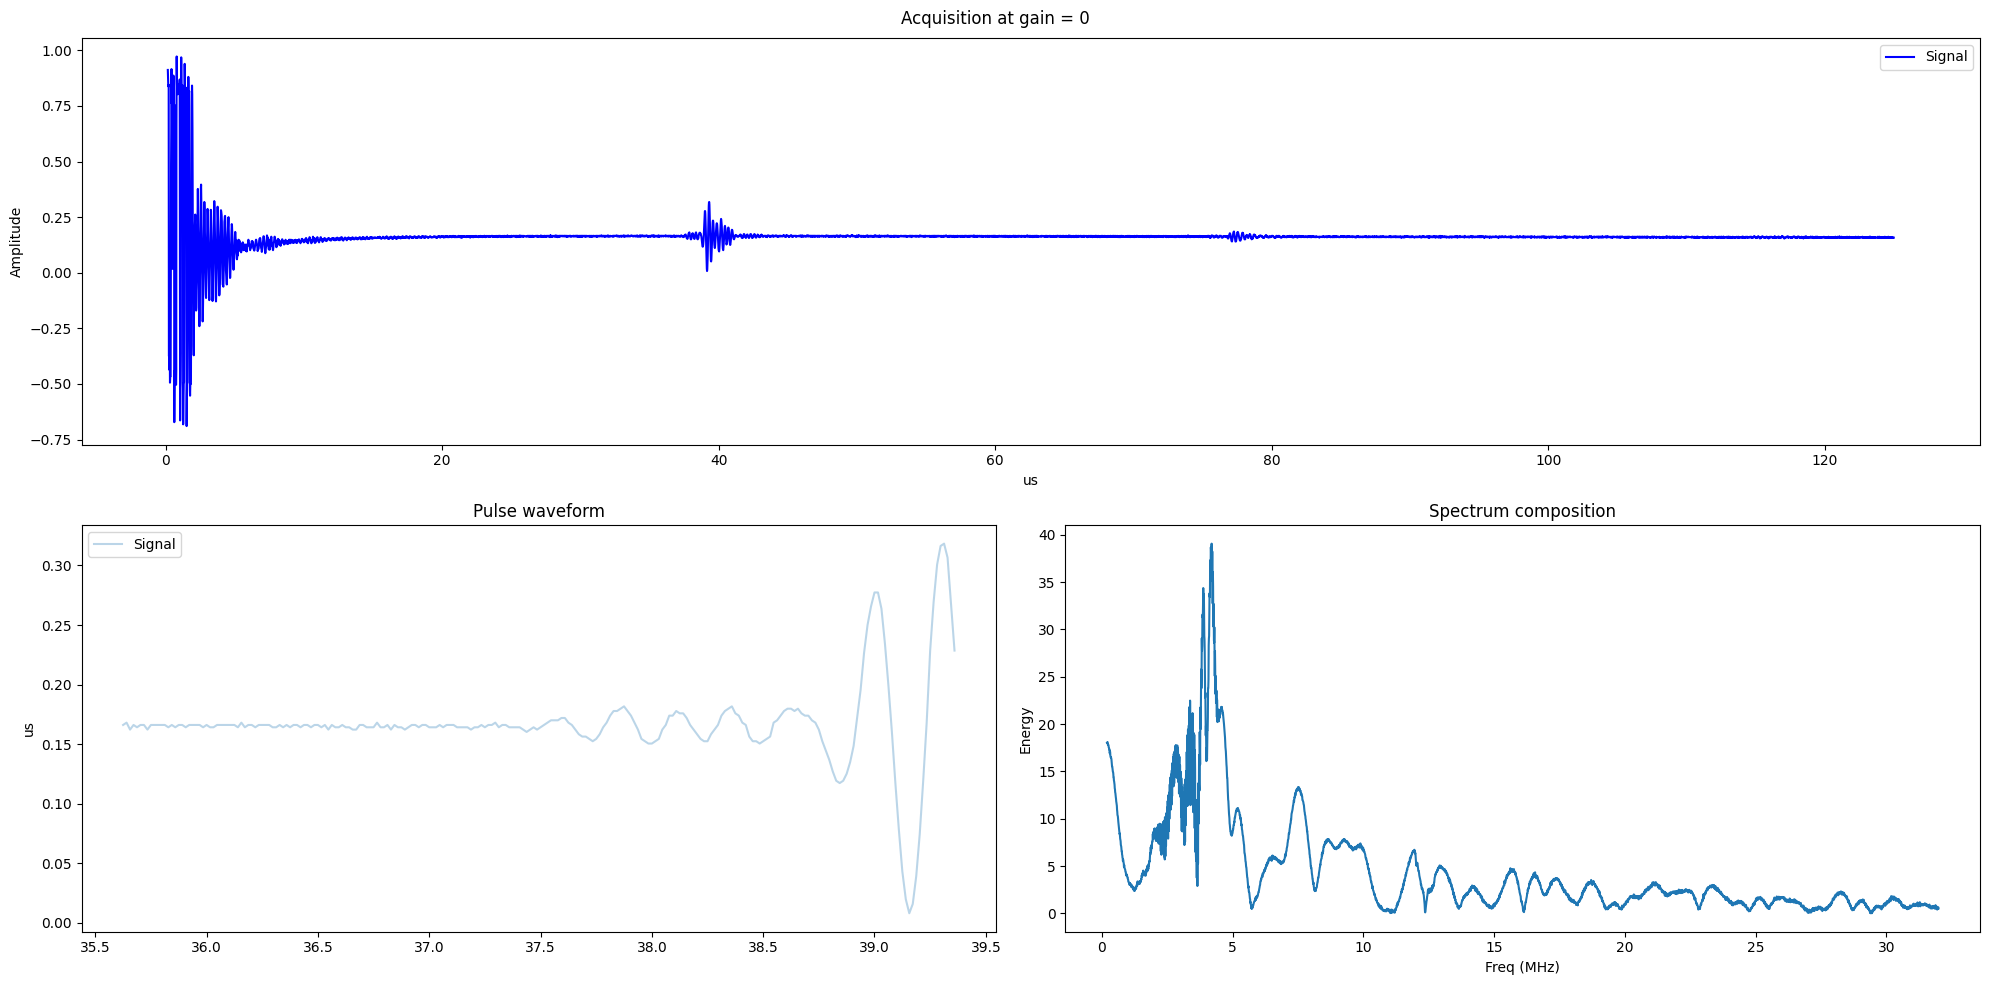

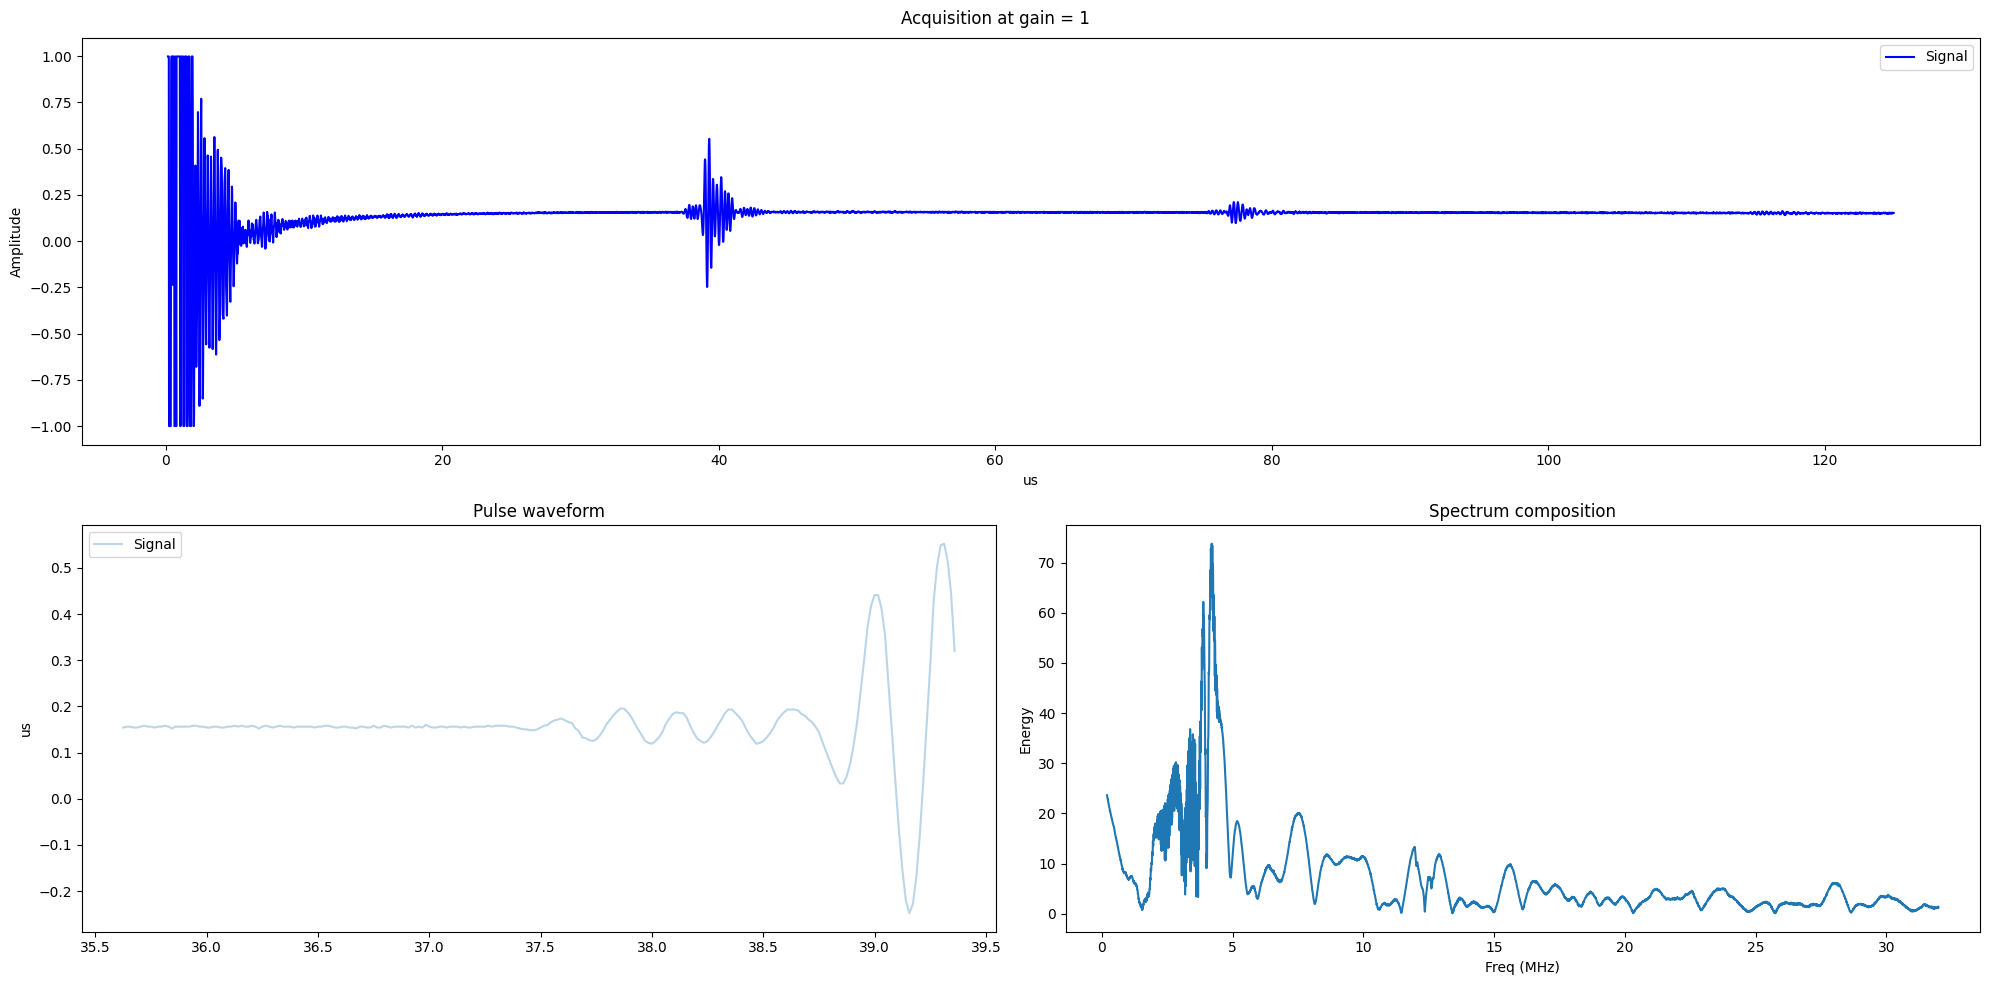

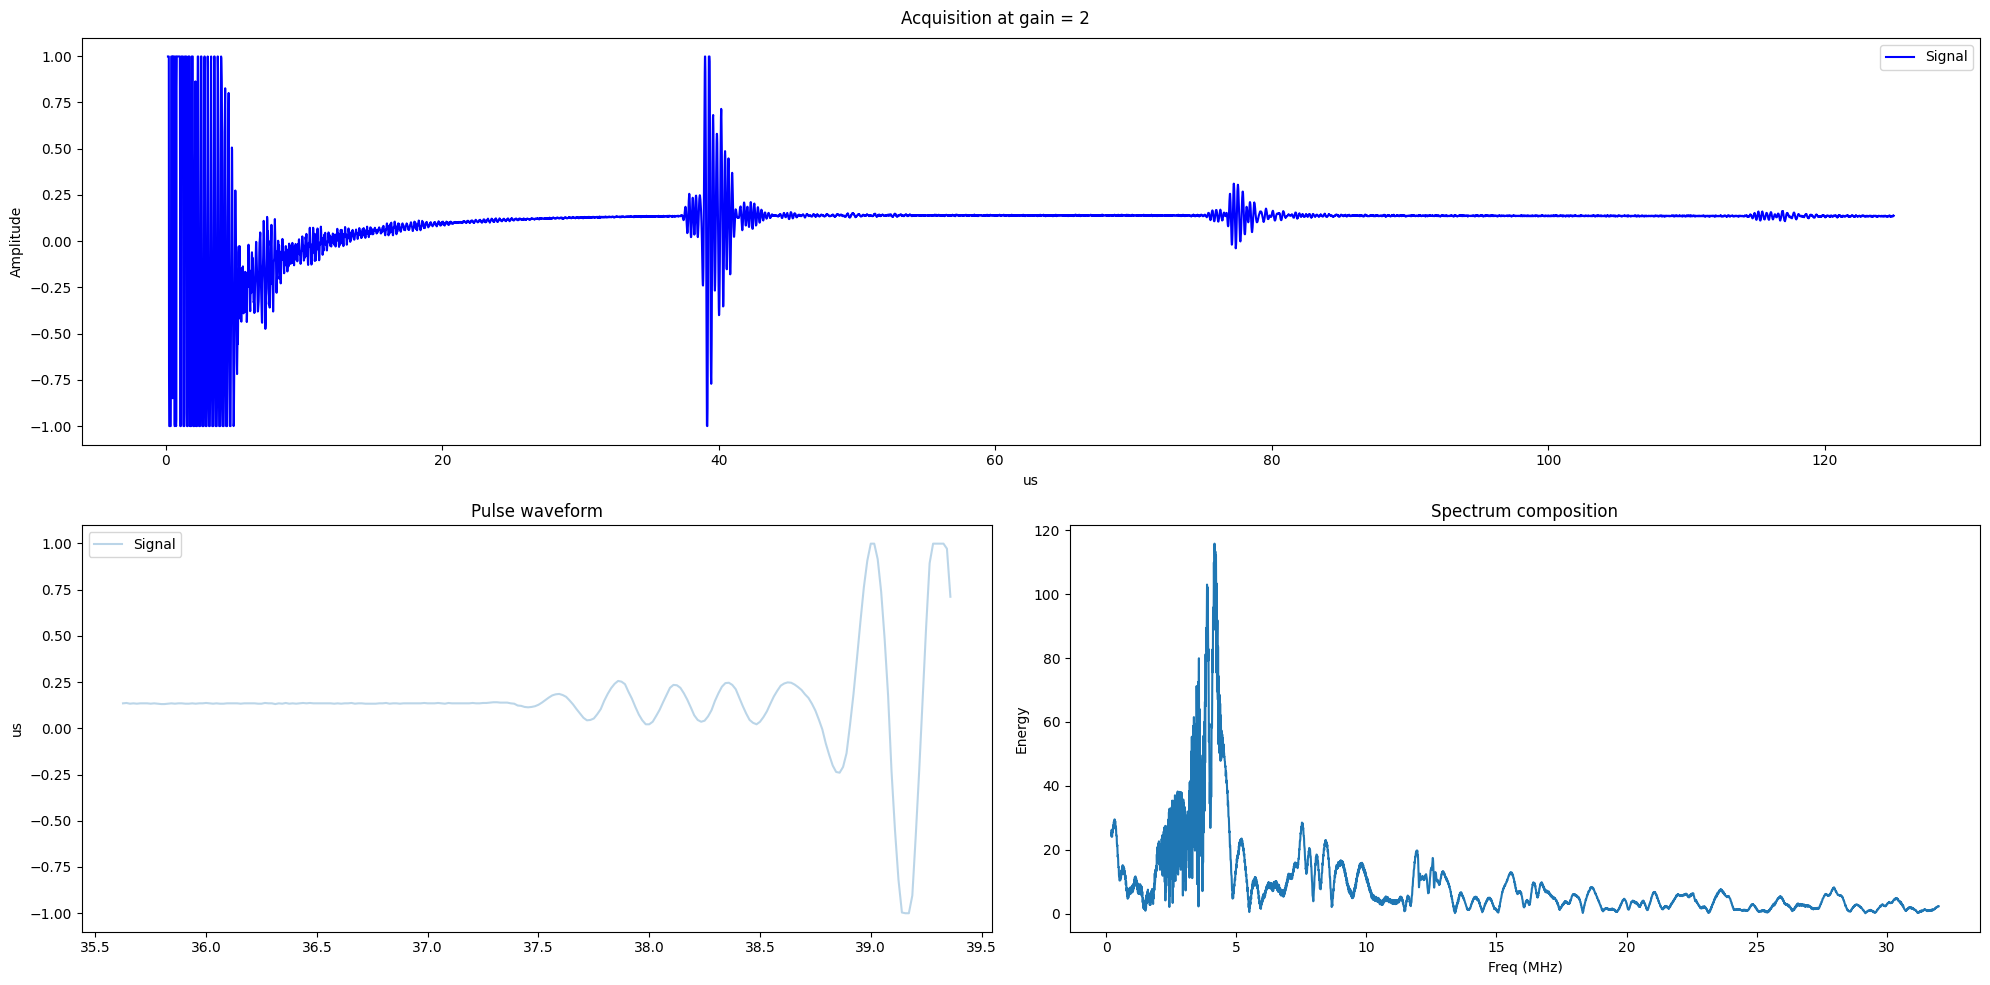

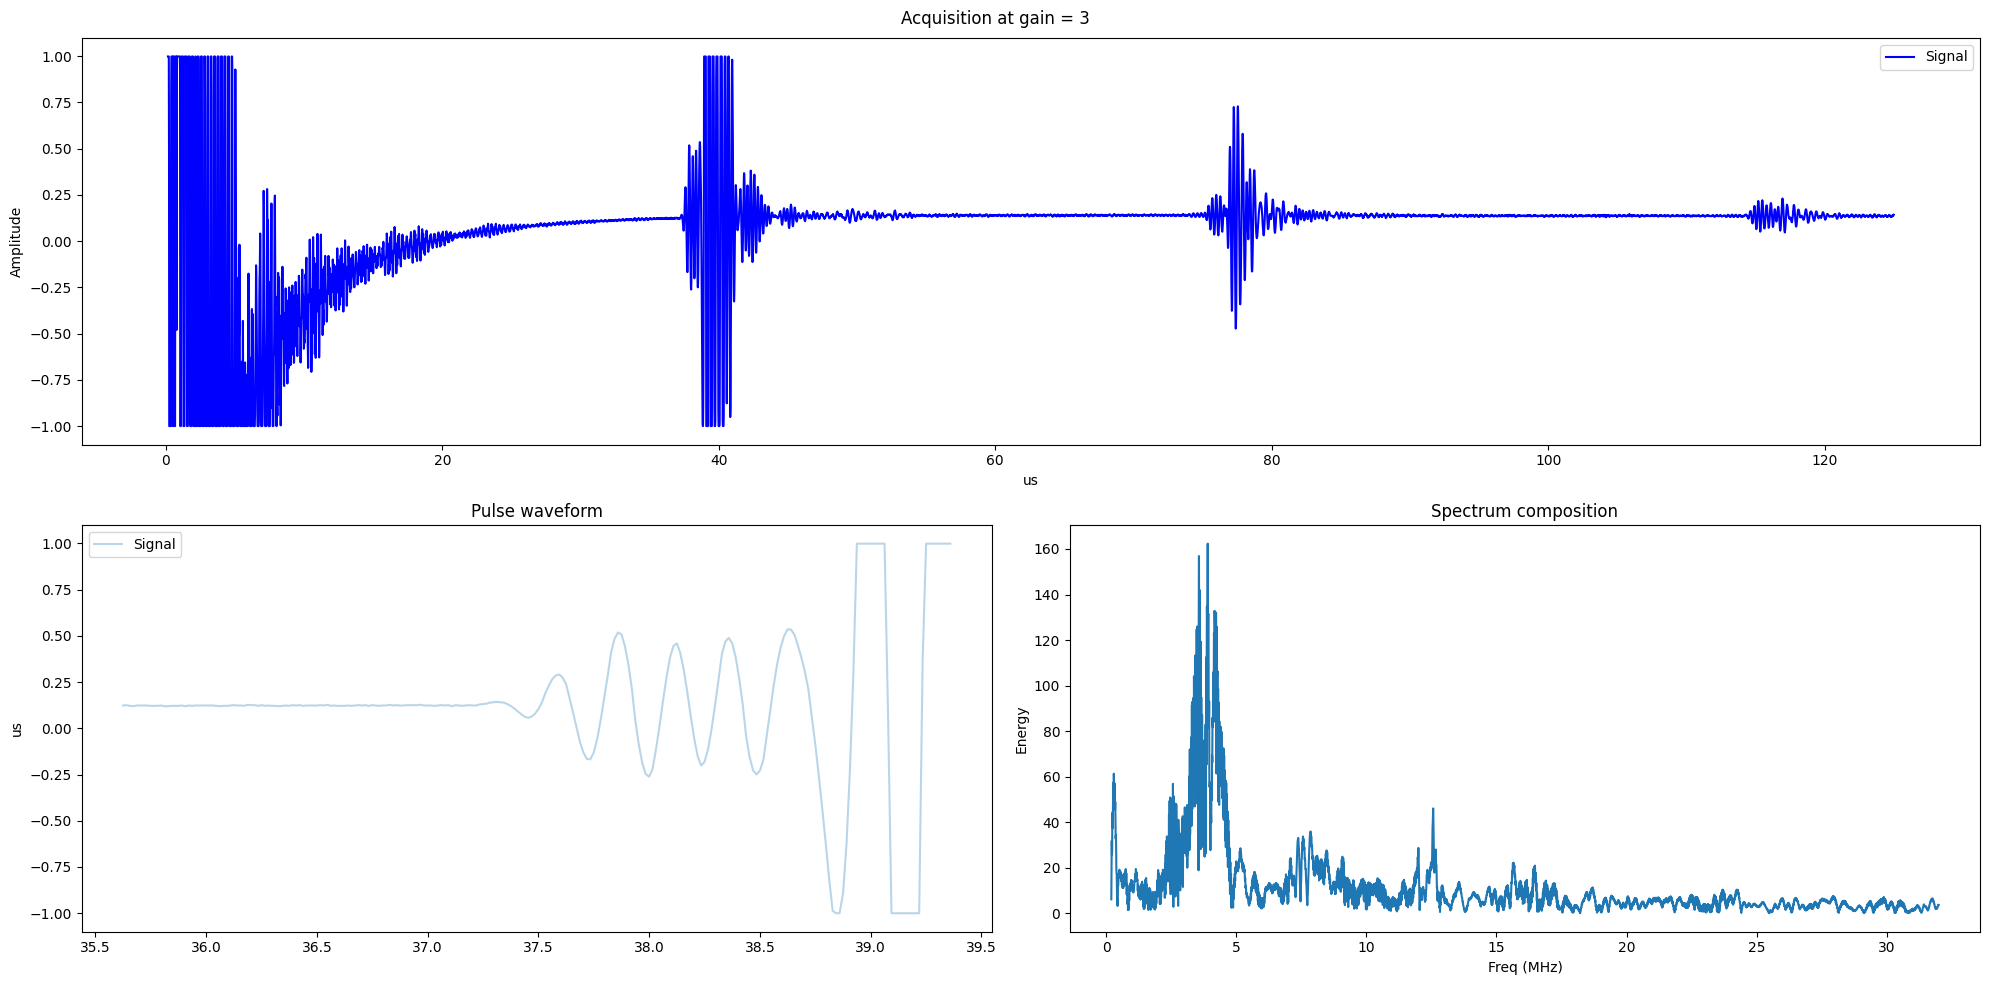

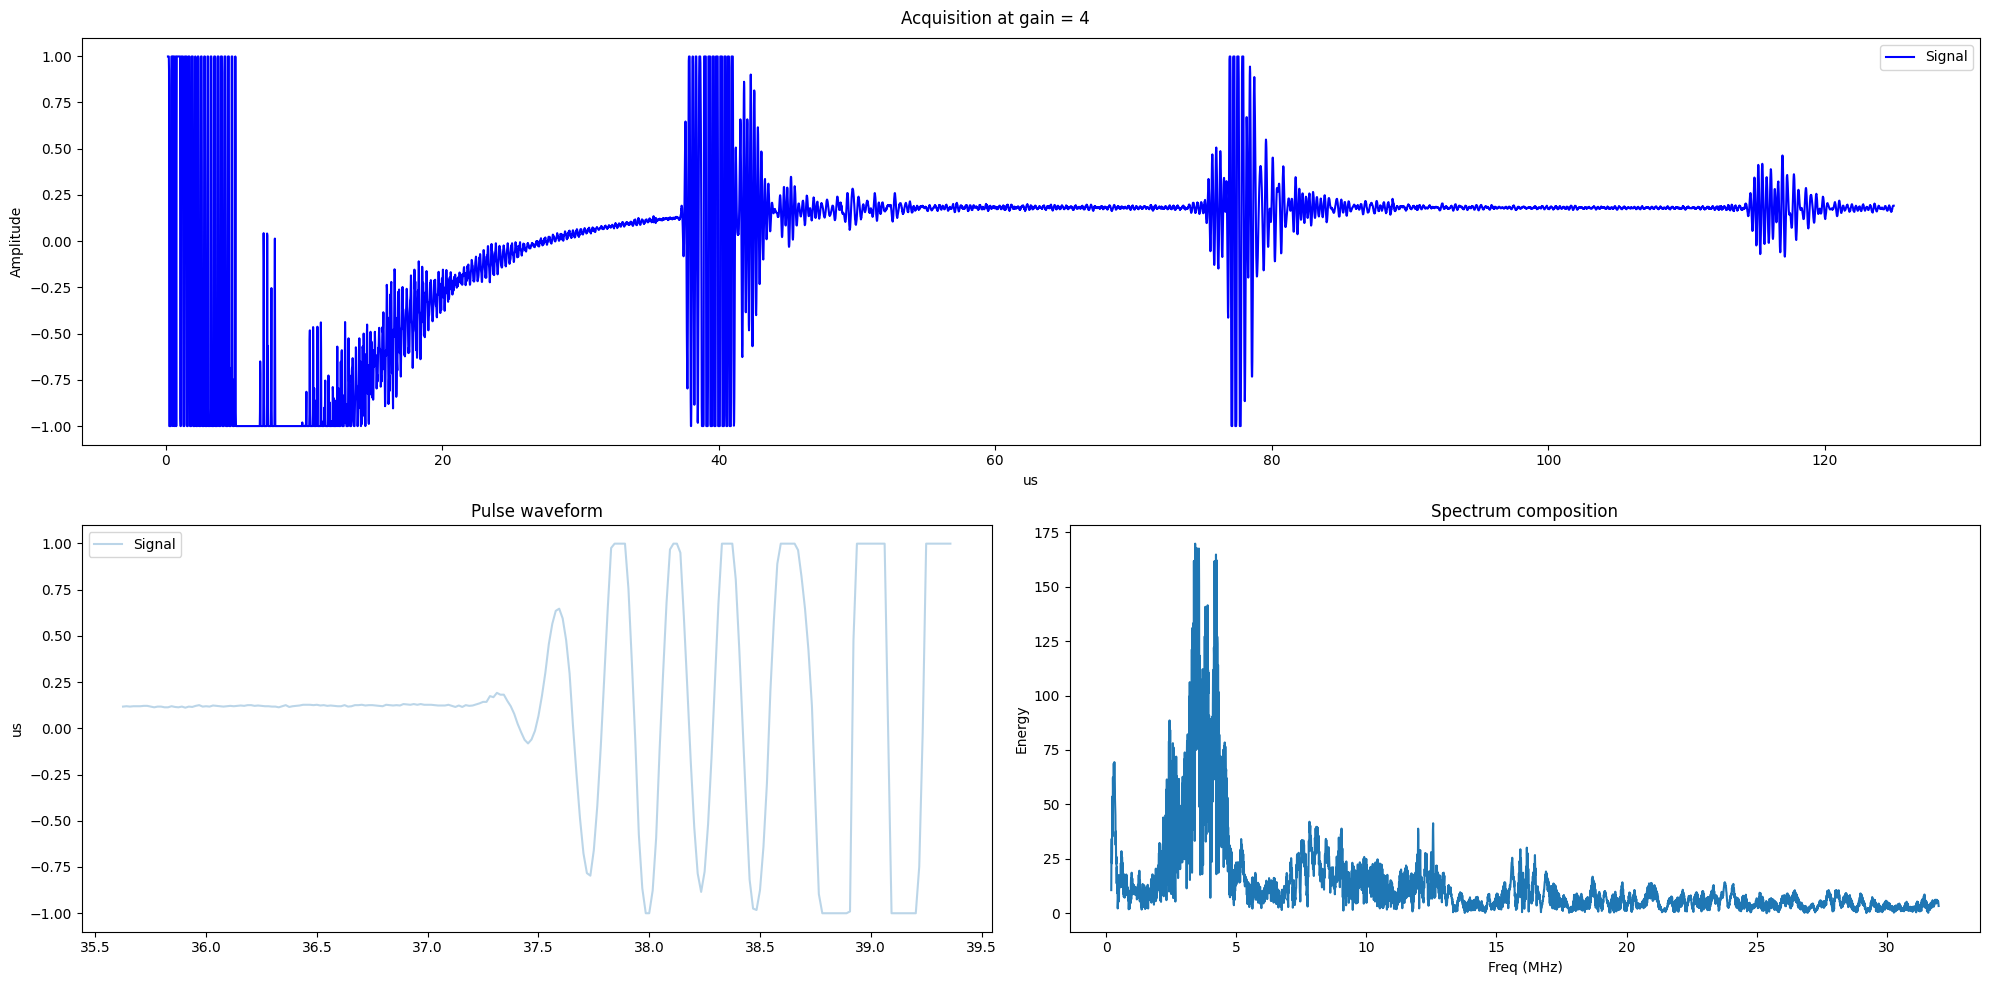

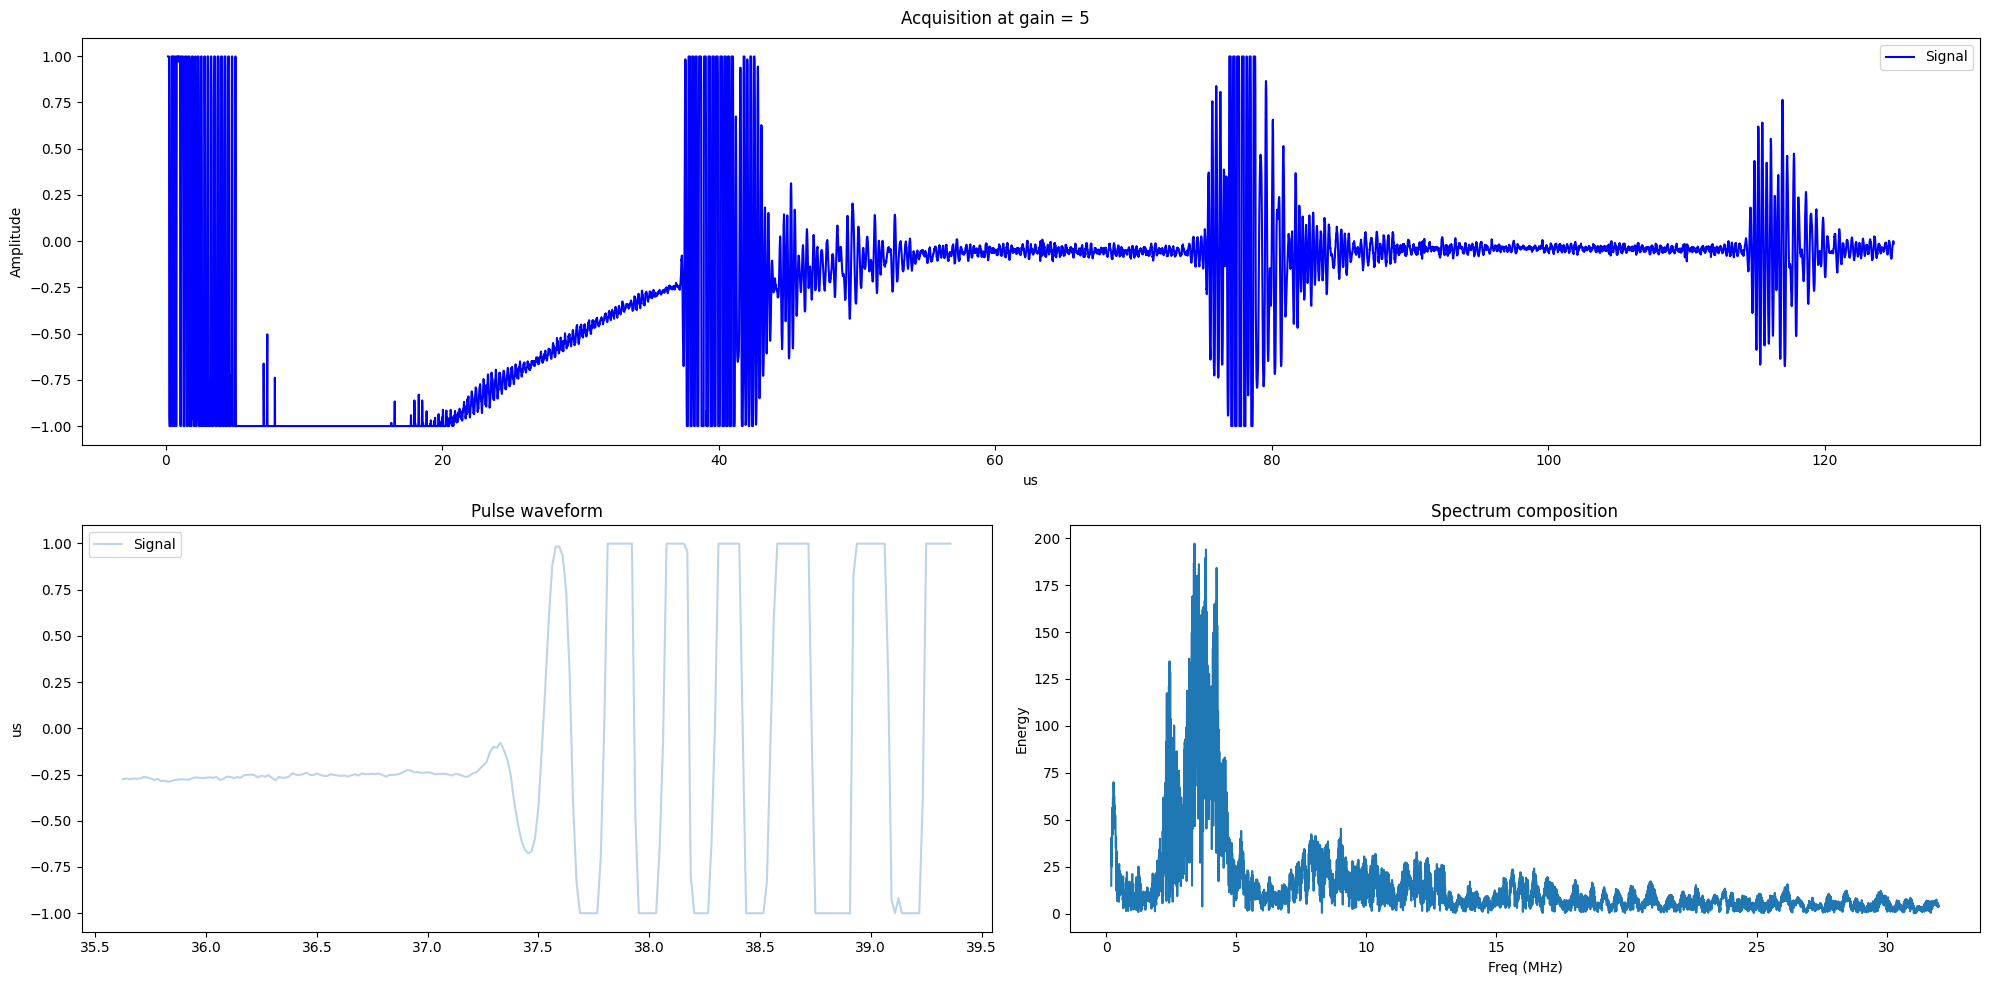

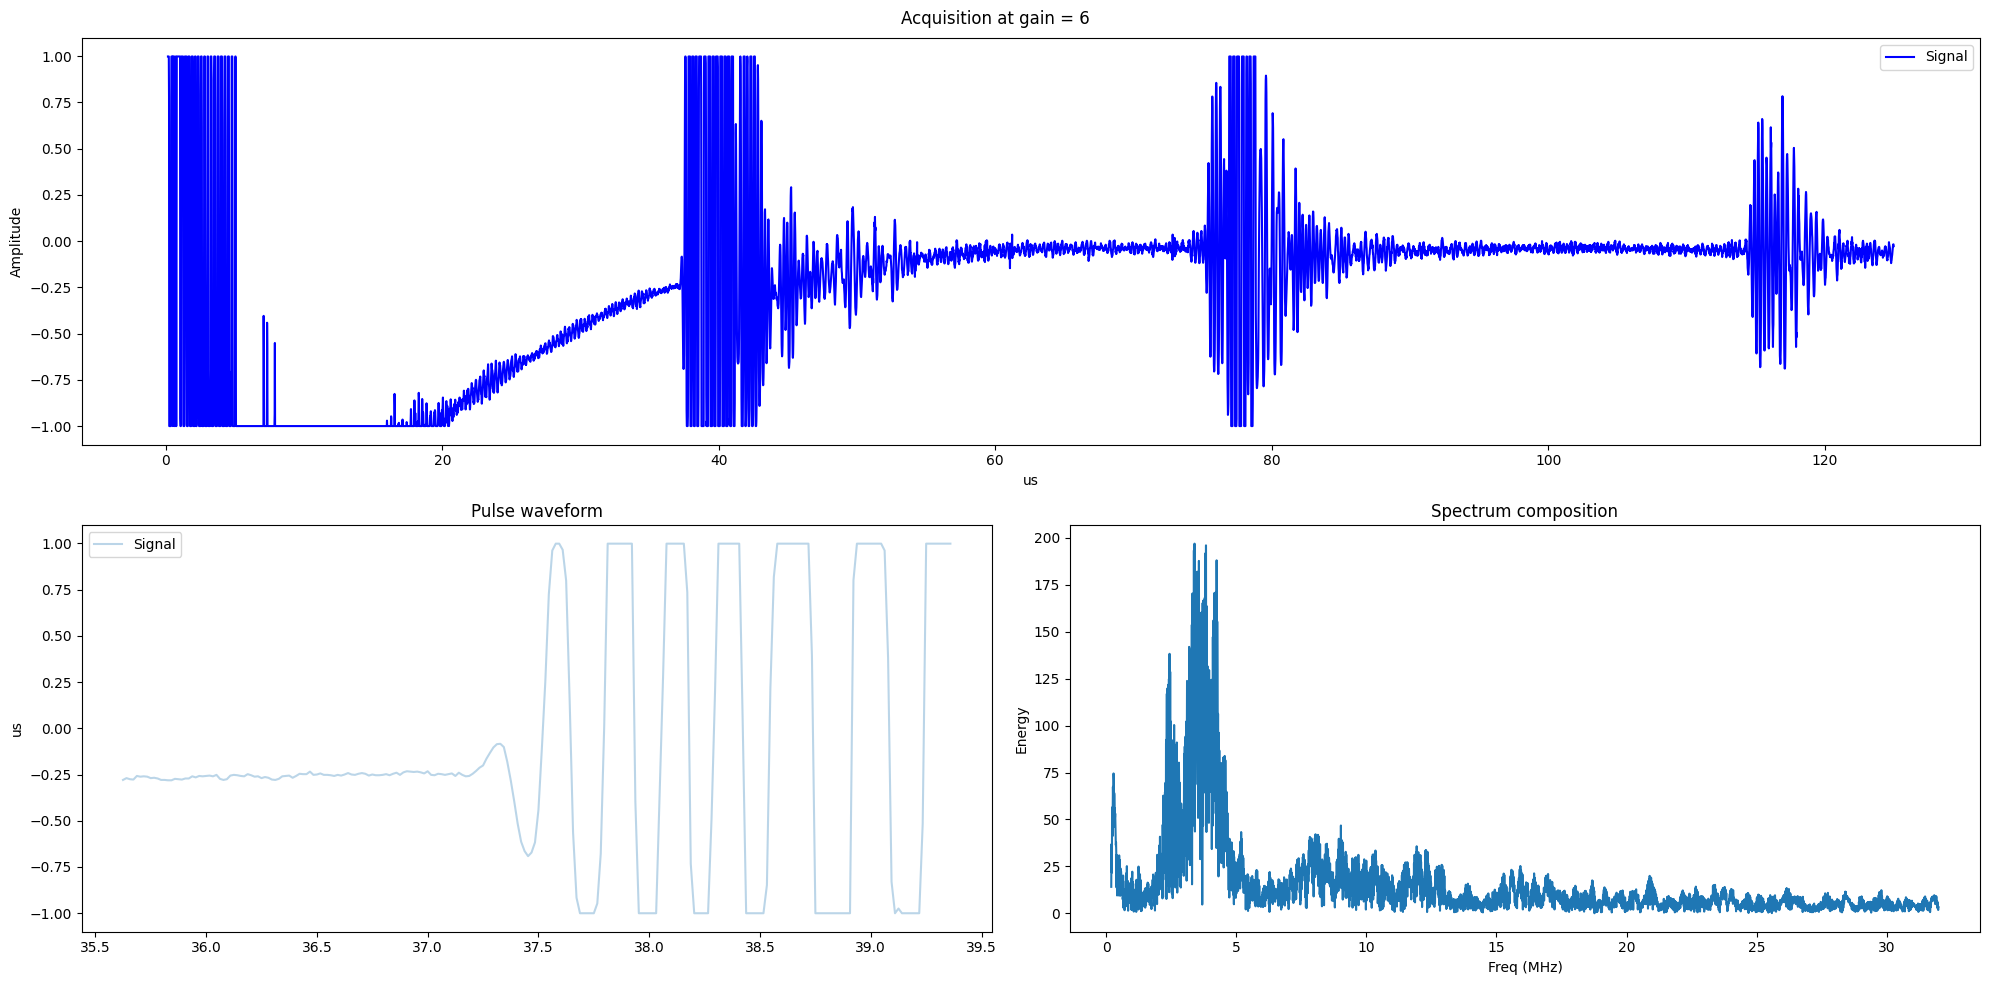

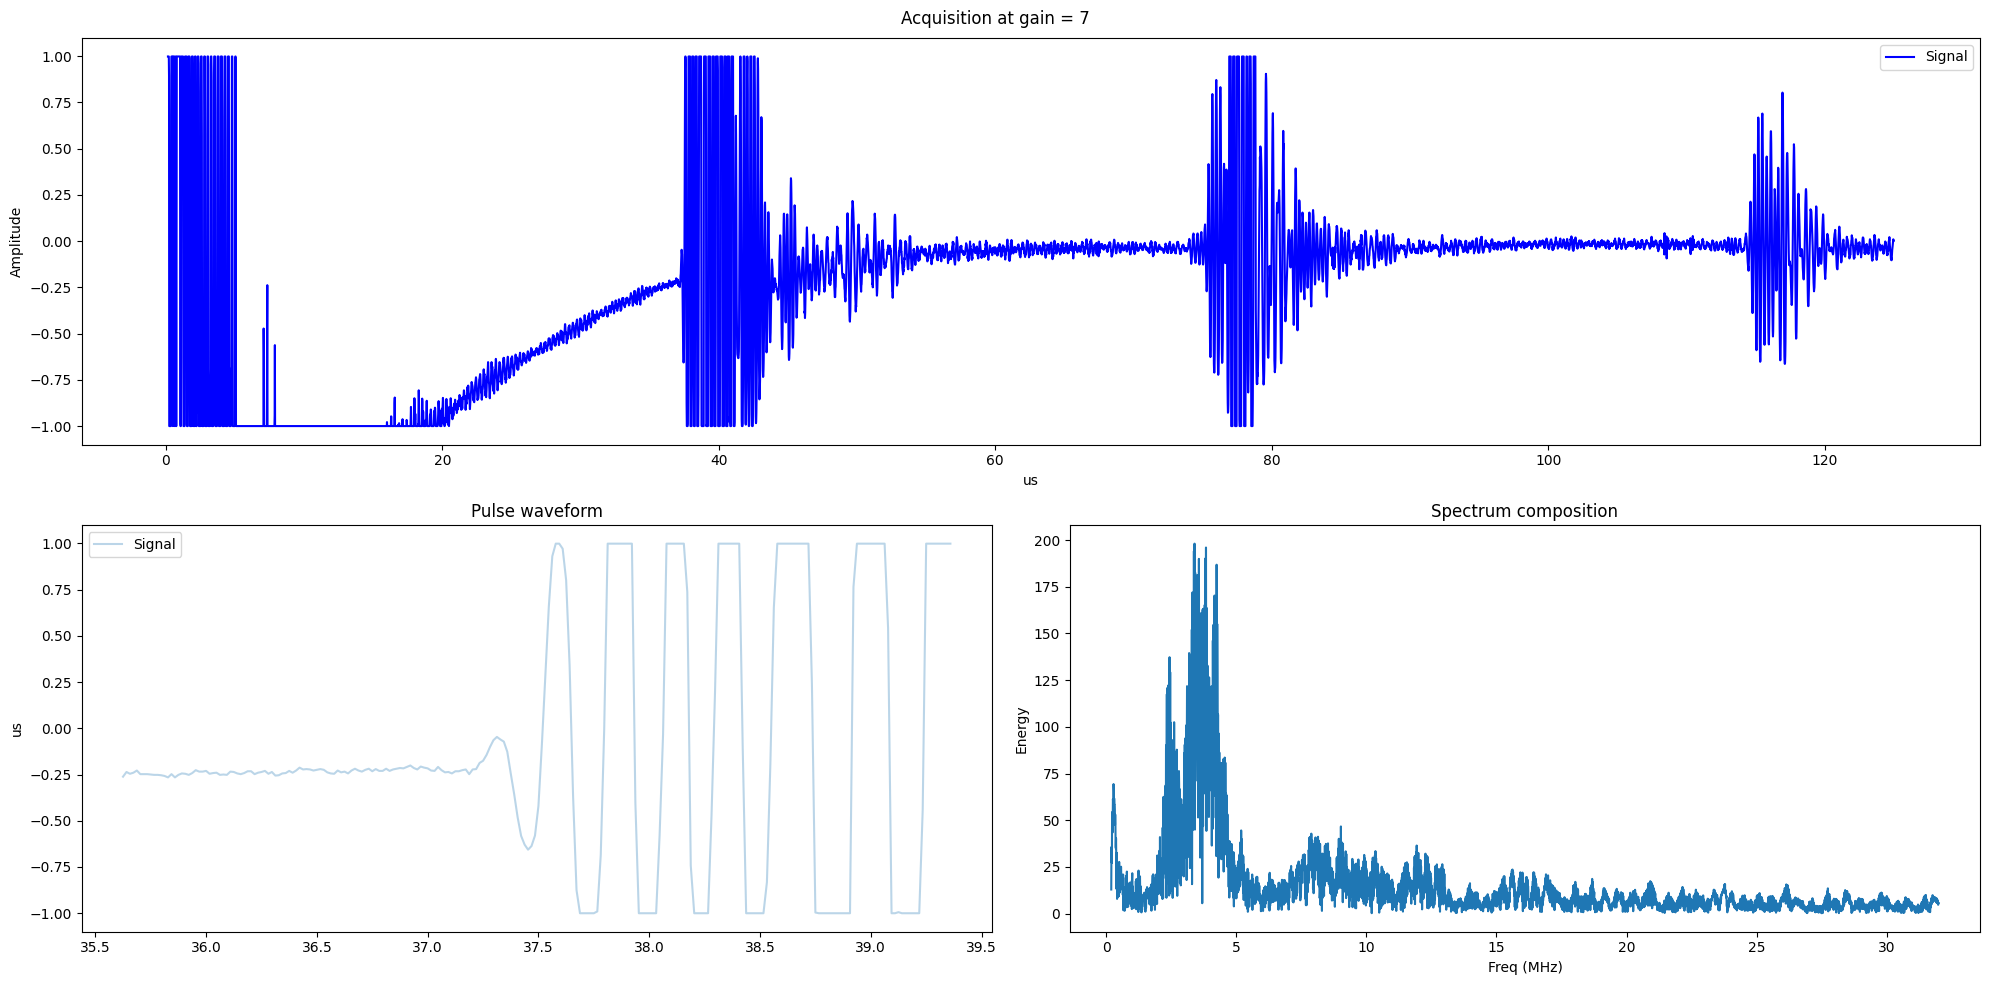

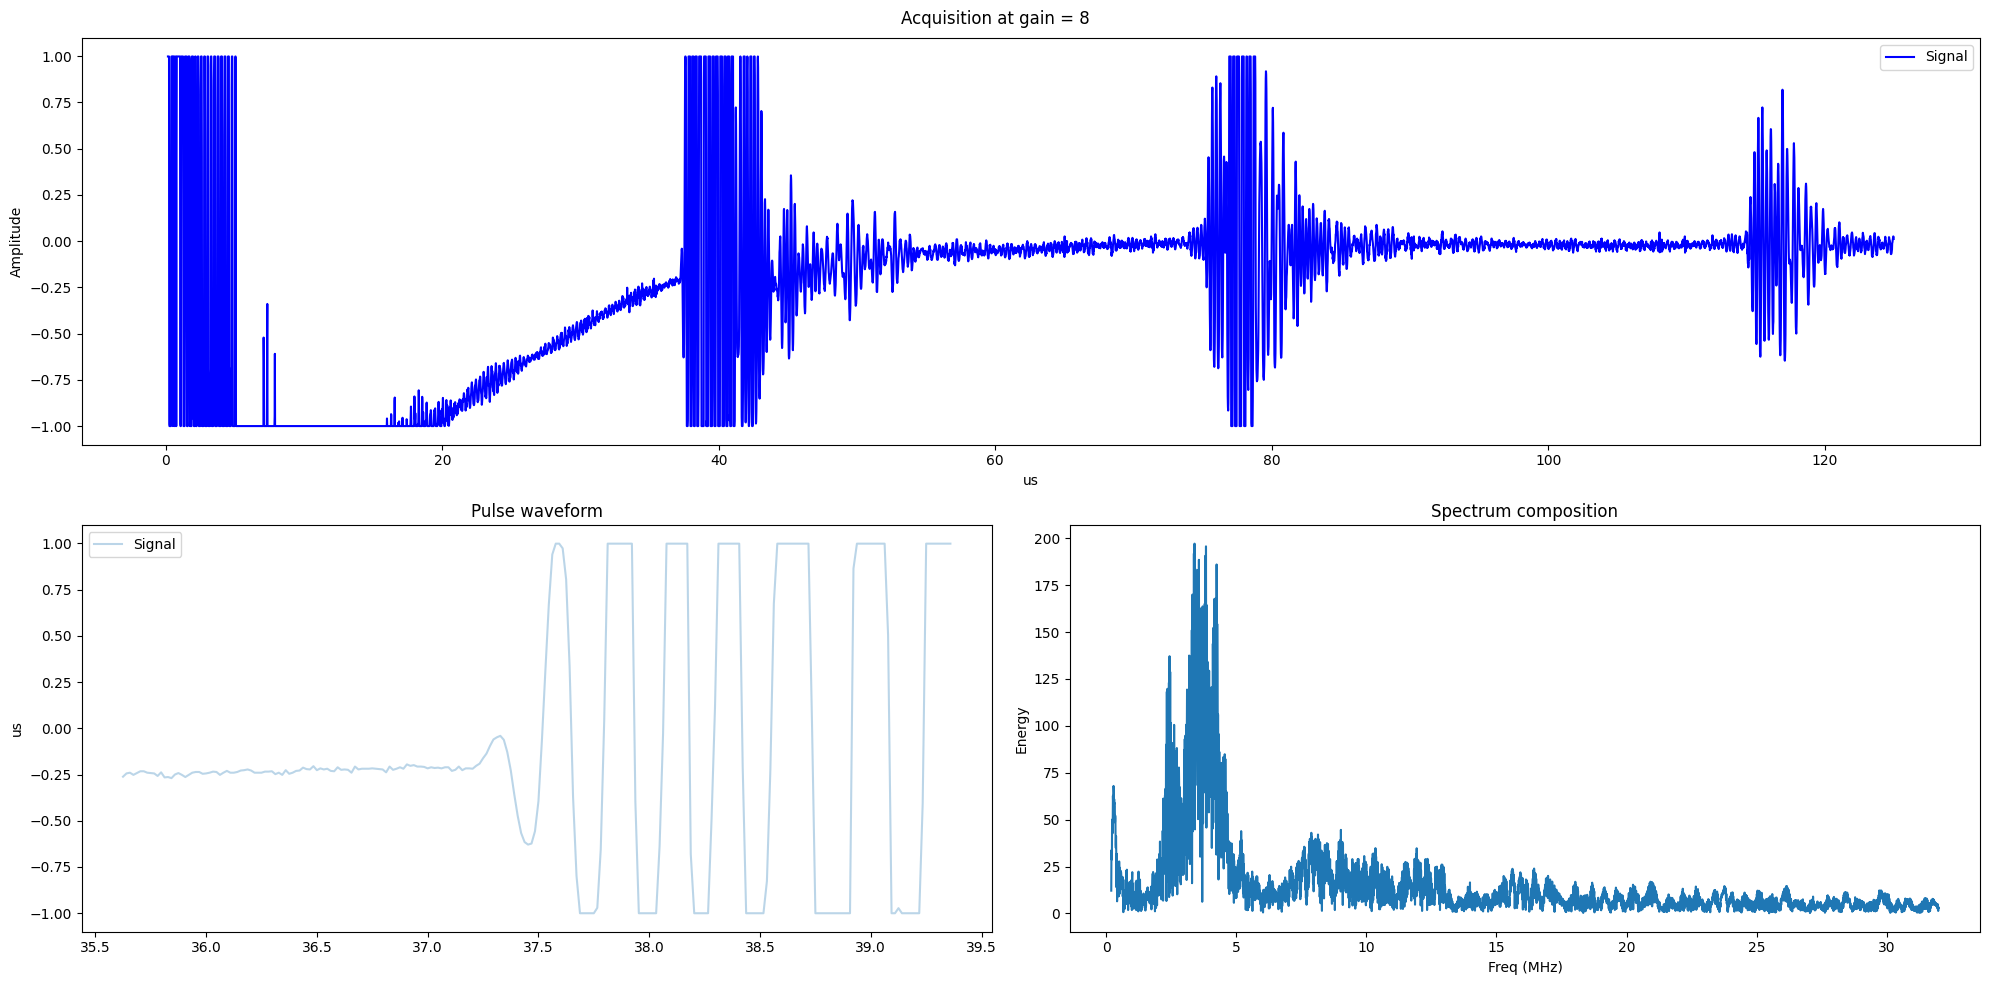

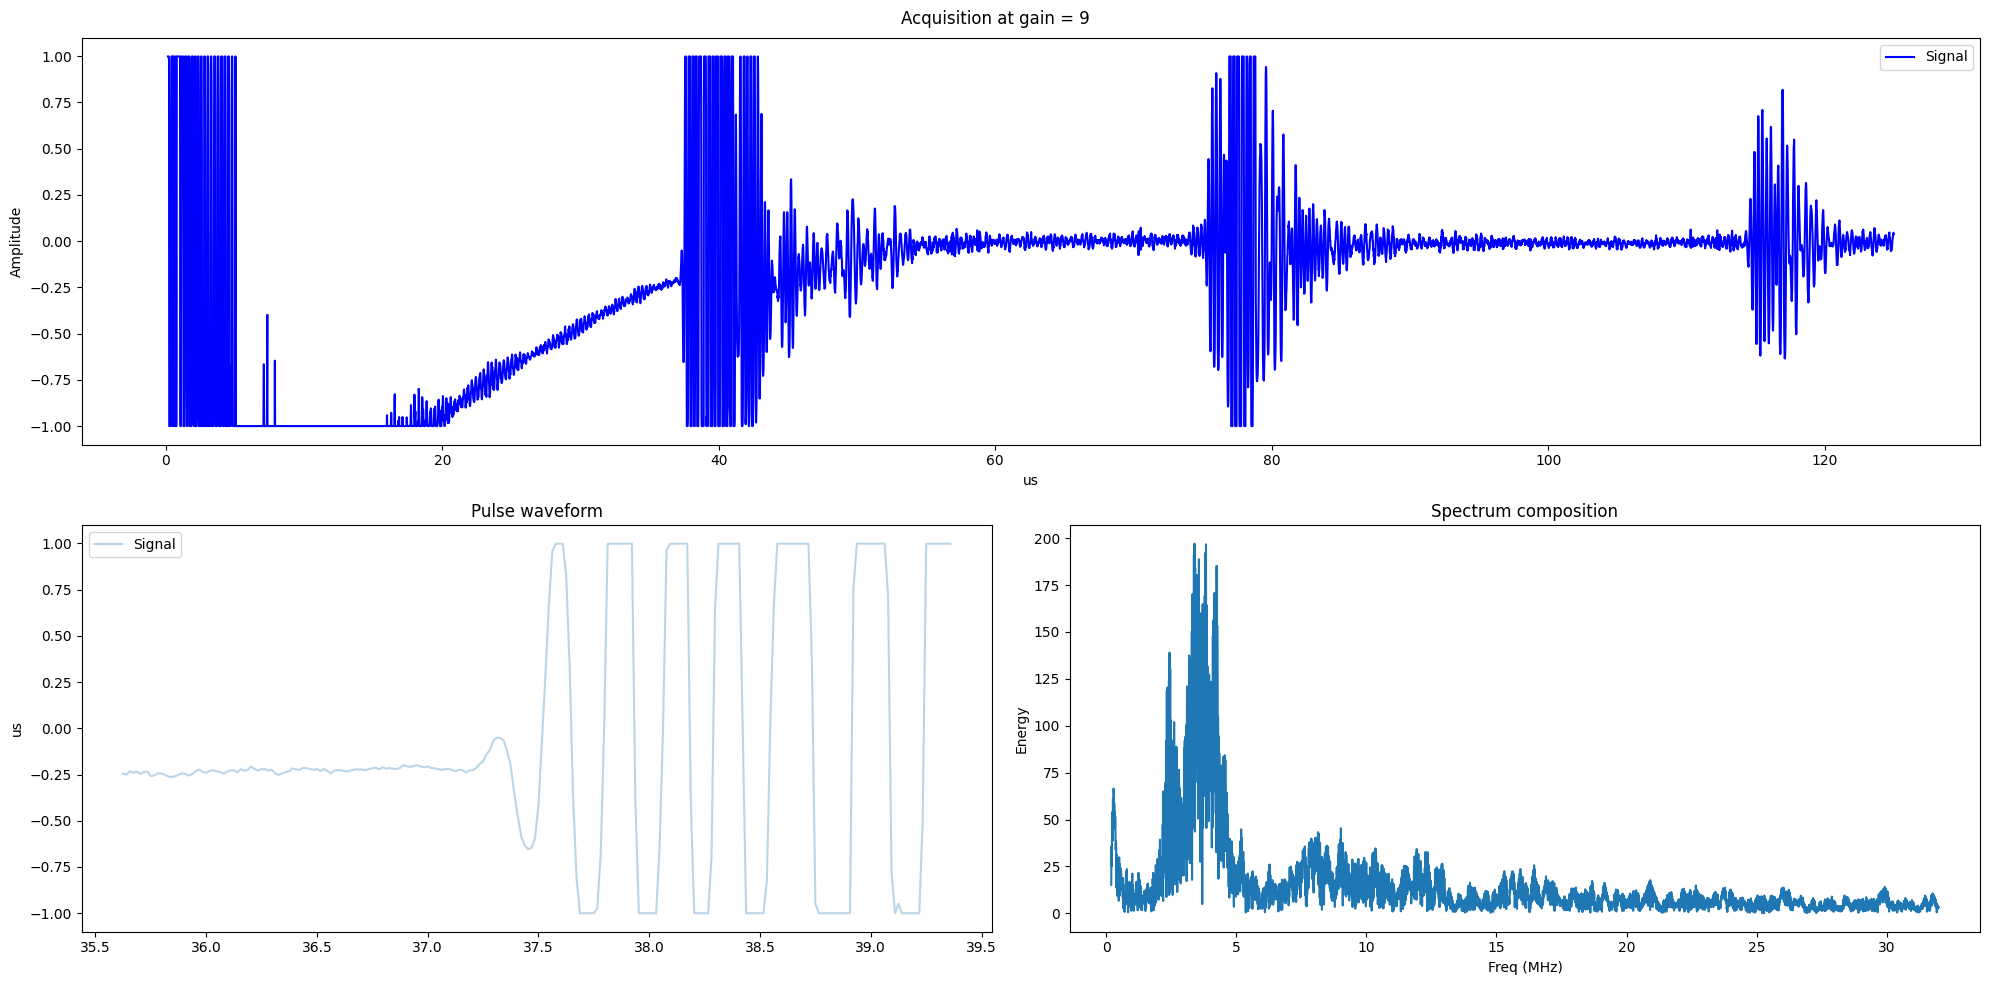

In [114]:
for G in range(10):
    dac(gain=G*100)
    pulse(pon=200,poff=200,damp=8000)
    signal = read()
    dac(gain=0)
    now = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
    t = [x/64.0 for x in range(len(signal))]
    f = [k*64/len(signal) for k in range(len(signal))]

    data = {"signal":signal,"t":t,"f":f,"gain":G,"timestamp":now}

    m=800

    FFT = np.abs(np.fft.fft(signal))

    plt.figure(figsize=(20,10))
    plt.subplot(2, 1, 1)

    plt.plot(t[10:],signal[10:],"b",label="Signal")
    plt.xlabel("us")
    plt.ylabel("Amplitude")
    plt.legend()
    title = "Acquisition at gain = " + str(G)

    plt.subplot(2, 2, 3)
    plt.plot(t[38*60:42*60],signal[38*60:42*60],alpha=0.3,label="Signal")
    plt.title('Pulse waveform')
    plt.ylabel('V')
    plt.ylabel('us')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title('Spectrum composition')
    plt.plot(f[25:len(FFT)//2],FFT[25:len(FFT)//2])
    plt.xlabel('Freq (MHz)')
    plt.ylabel('Energy')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig("imgs/pico_shell/pic0gain_at_"+str(G)+".jpg")
    np.savez_compressed("imgs/pico_shell/pic0gain_at_"+str(G), **data )